In [284]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats

In [285]:
sys.path.append('D:\my github\Siyi Applied Stats\Documents for JN\AppStat2021-main\External_Functions\\')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

In [286]:
r = np.random
r.seed(42)

save_plots = False  
N_points = 12000    # Number of random points to be generated

In [287]:
xmin2, xmax2 = 0,1         # Note the simple/short notation.
ymax2 = 3                         # This is not the maximum but above, which is OK though less efficient!

In [288]:
x_cos = np.zeros(N_points)
Ntry = 0

for i in range(N_points):
    while True:
        Ntry += 1
        x2 = r.uniform(xmin2, xmax2)  
        y2 = r.uniform(0,     ymax2)        
        if (y2 < 8*x2**3*np.sin(np.pi*x2)) :   # If the (x,y)-point fulfills the accept condition...
            break
            
    x_cos[i] = x2                   # ...then break and accept the x-value

In [289]:
eff = N_points / Ntry                        # Efficiency of generating points (fraction accepted)
eff_error = np.sqrt(eff * (1-eff) / Ntry)    # Error on efficiency (binomial)
integral =  eff * (xmax2-xmin2) * ymax2               # Integral
integral_error = eff_error * (xmax2-xmin2) * ymax2    # Error on integral

print(f"Integral of g(x) = x*cos(x), x in [0, pi/2] is: \t {integral:7.4f} +- {integral_error:6.4f}")
print(f"The efficiency of the accept/reject method is:  \t {eff:.2%} +/- {eff_error:.2%}")
# Since the integral of x*cos in [0,pi/2] is around 0.57, the proper normalisation is 1/0.57

Integral of g(x) = x*cos(x), x in [0, pi/2] is: 	  0.9989 +- 0.0074
The efficiency of the accept/reject method is:  	 33.30% +/- 0.25%


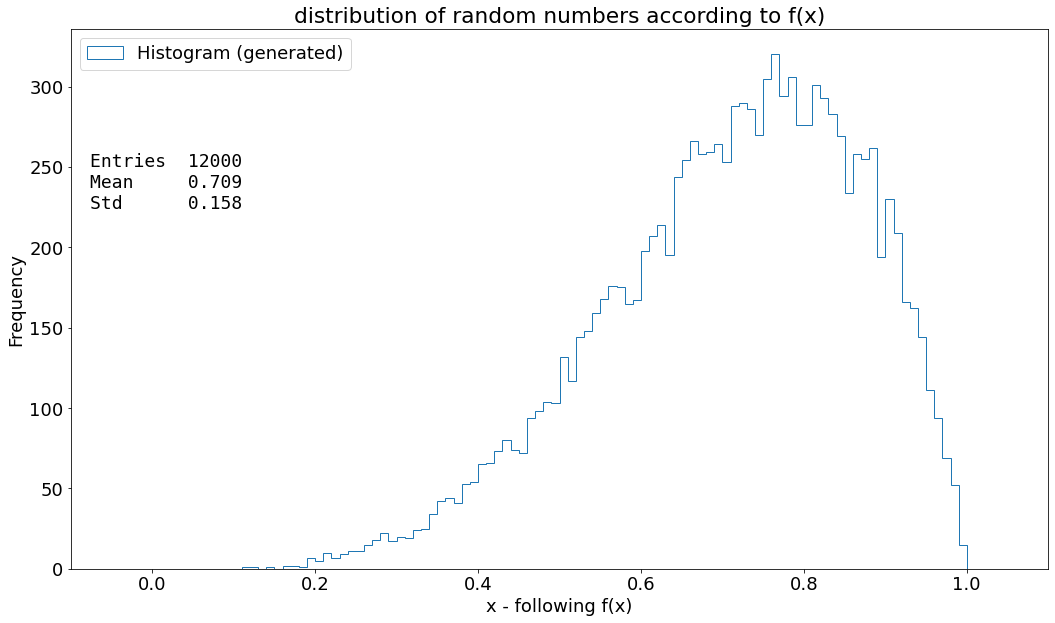

In [296]:
Nbins = 100

fig2, ax2 = plt.subplots(figsize=(15, 9))
ax2.hist(x_cos, bins=Nbins, range=(xmin2, xmax2), histtype='step', label='Histogram (generated)' )
ax2.set(xlabel="x - following f(x)", ylabel="Frequency", xlim=(xmin2-0.1, xmax2+0.1))



# Define the figure text
d2 = {'Entries': len(x_cos),
      'Mean': x_cos.mean(),
      'Std': x_cos.std(ddof=1),
    }

# Add figure text
text2 = nice_string_output(d2, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.77, text2, ax2, fontsize=18)

# Add legend
ax2.legend(loc='upper left')
plt.title('distribution of random numbers according to f(x)')
fig2.tight_layout()


In [291]:
def fit_pdf(x,a) :
    k = (xmax2-xmin2) / Nbins
    N = N_points * k
    return N * 1.0/integral *8*x**a*np.sin(np.pi*x)     # Normalize the function by adding a factor 1.0/integral

In [292]:
x_all=x_cos
xmin, xmax=xmin2, xmax2
counts, bin_edges = np.histogram(x_all, bins=Nbins, range=(xmin, xmax))
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0]) 

In [293]:

Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)

# Defining Chi2 calculation:
def chi2_owncalc(a) :
    y_fit = fit_pdf(x,a)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2

# Alternatively, use the Chi2 regression from External Functions:
chi2fit = Chi2Regression(fit_pdf,x, y, sy)

minuit_chi2 = Minuit(chi2_owncalc,a=3)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 68.04                      │              Nfcn = 16               │
│ EDM = 2.42e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   3.03    │   0.02    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        a │
├───┼──────────┤
│ a │ 0.000401 │
└───┴──────────┘

In [294]:

# First, check if the result was a valid minimum:
if (not minuit_chi2.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    
    
# Short hand way of accessing the fit parameters:
fit_a= minuit_chi2.values[:]   # The fitted values of the parameters

# Loop to get both parameter values and uncertainties:
for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")


Fit value: a = 3.03004 +/- 0.02003
Chi2 value: 68.0   Ndof = 86    Prob(Chi2,Ndof) = 0.923


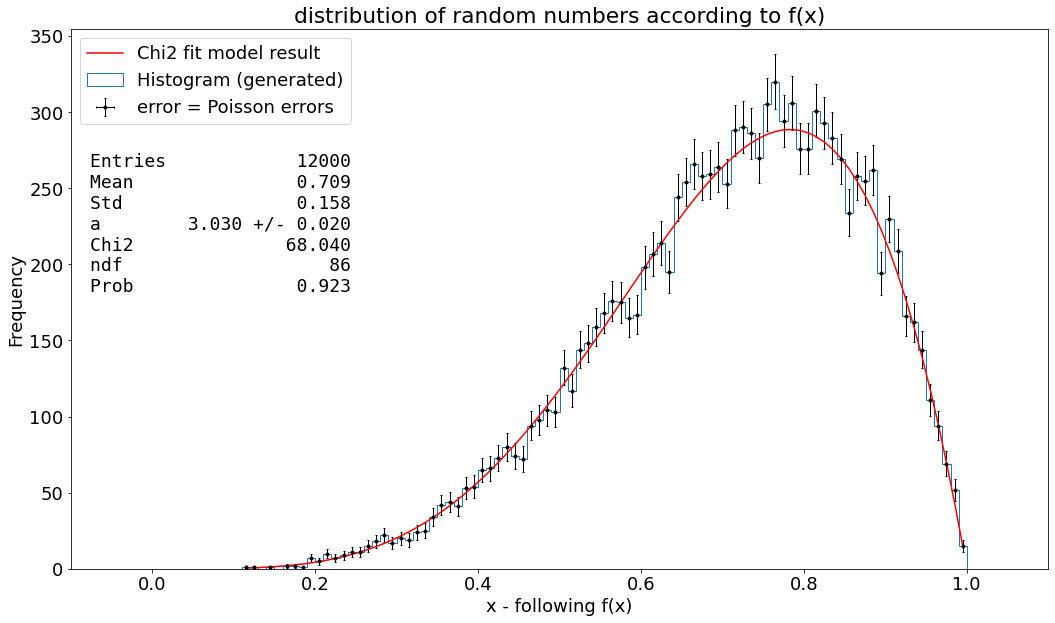

In [295]:
Nbins = 100

fig2, ax2 = plt.subplots(figsize=(15, 9))

ax2.hist(x_cos, bins=Nbins, range=(xmin2, xmax2), histtype='step', label='Histogram (generated)' )
ax2.set(xlabel="x - following f(x)", ylabel="Frequency", xlim=(xmin2-0.1, xmax2+0.1))

ax2.errorbar(x, y, yerr=sy, xerr=0.0, label='error = Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

x_axis = np.linspace(xmin, xmax, 100)
ax2.plot(x, fit_pdf(x, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

# Define the figure text
d2 = {'Entries': len(x_cos),
      'Mean': x_cos.mean(),
      'Std': x_cos.std(ddof=1),
      
      'a': [minuit_chi2.values['a'], minuit_chi2.errors['a']],
      'Chi2':     chi2_value,
      'ndf':      Ndof_value,
      'Prob':     Prob_value,
    }

# Add figure text
text2 = nice_string_output(d2, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.77, text2, ax2, fontsize=18)



# Add legend
ax2.legend(loc='upper left')
plt.title('distribution of random numbers according to f(x)')
fig2.tight_layout()

# Save figure
fig2.savefig("fig2.png", dpi=600)